<a href="https://colab.research.google.com/github/lucywowen/csci547_ML/blob/main/examples/ridge_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programming Exercise: Comparing Regression Techniques

> This exercise has been adapted from this Medium article, found [here](https://medium.com/coinmonks/regularization-of-linear-models-with-sklearn-f88633a93a2).


> In this exercise, you will implement regularization by using Ridge Regression and apply it to the Boston housing prices datasets from Kaggle.  You'll find the data in the 'csci547_ML/examples/data/boston-housing' or [here](https://www.kaggle.com/competitions/boston-housing/data).  

If you are running this in Google's Colab, you can use this code to import the data.  

In [11]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv
Saving train.csv to train (1).csv
Saving submission_example.csv to submission_example (1).csv


>Linear models are usually a good starting point for training a model. However, a lot of datasets do not exhibit linear relationships between the independent and the dependent variables. As a result, it is frequently necessary to create a polynomial model. However, these models are usually prone to overfitting. One method of reducing overfitting in polynomial models is through the use of regularization.

>Let’s start by building a baseline model to determine the required improvement. We will make use of the popular Boston Housing dataset which is available on Kaggle.  

Let’s import the necessary libraries and load up our training dataset.

In [12]:
import numpy as np
import pandas as pd
import math

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error # Note that we'll be using MSE for errors but this is something we could change

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline


And now lets import the data (depending on your envirnment/data location this cell will need to change).

In [13]:
#import training dataset
train_df = pd.read_csv('train.csv', index_col='ID')

#see the columns in our data
train_df.info()

# take a look at the head of the dataset
train_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 1 to 506
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     333 non-null    float64
 1   zn       333 non-null    float64
 2   indus    333 non-null    float64
 3   chas     333 non-null    int64  
 4   nox      333 non-null    float64
 5   rm       333 non-null    float64
 6   age      333 non-null    float64
 7   dis      333 non-null    float64
 8   rad      333 non-null    int64  
 9   tax      333 non-null    int64  
 10  ptratio  333 non-null    float64
 11  black    333 non-null    float64
 12  lstat    333 non-null    float64
 13  medv     333 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 39.0 KB


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
ID,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


## Data description
The Boston data frame has 506 rows and 14 columns.

This data frame contains the following columns:

- crim
  -  per capita crime rate by town.

- zn
  - proportion of residential land zoned for lots over 25,000 sq.ft.

- indus
   - proportion of non-retail business acres per town.

- chas
  - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

- nox
   - nitrogen oxides concentration (parts per 10 million).

- rm
  - average number of rooms per dwelling.

- age
  - proportion of owner-occupied units built prior to 1940.

- dis
  - weighted mean of distances to five Boston employment centres.

- rad
  - index of accessibility to radial highways.

- tax
  - full-value property-tax rate per \$10,000.

- ptratio
  - pupil-teacher ratio by town.

- black
  - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town.

- lstat
  - lower status of the population (percent).

- medv
  - median value of owner-occupied homes in \$1000s.



Just to check out the code and see what we're dealing with, lets start by plotting the distribution of the median values of the homes (this is in $1Ks of dollars)

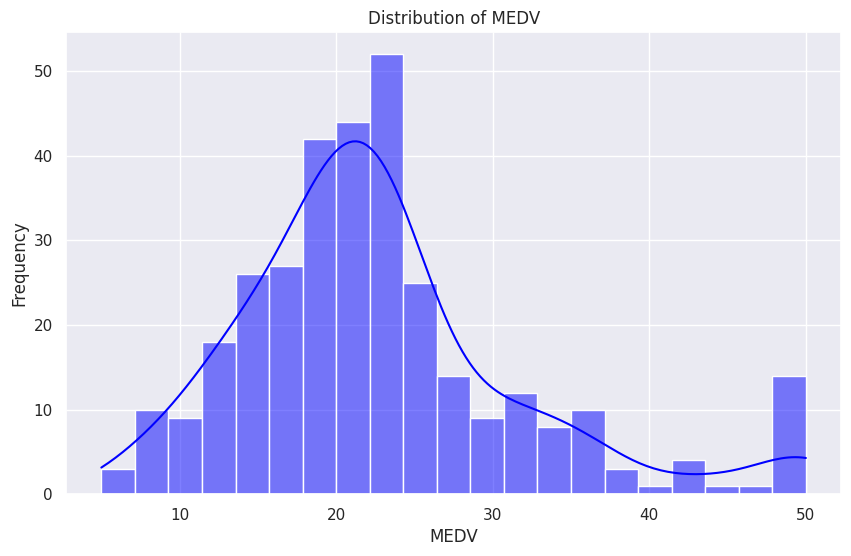

In [ ]:
# Distribution of MEDV
plt.figure(figsize=(10, 6))
sns.histplot(train_df['medv'], kde=True, color='blue')
plt.title('Distribution of MEDV')
plt.xlabel('MEDV')
plt.ylabel('Frequency')
plt.show()

And lets plot the correlation matrix for the data to see how medv is correlated with all these other features.

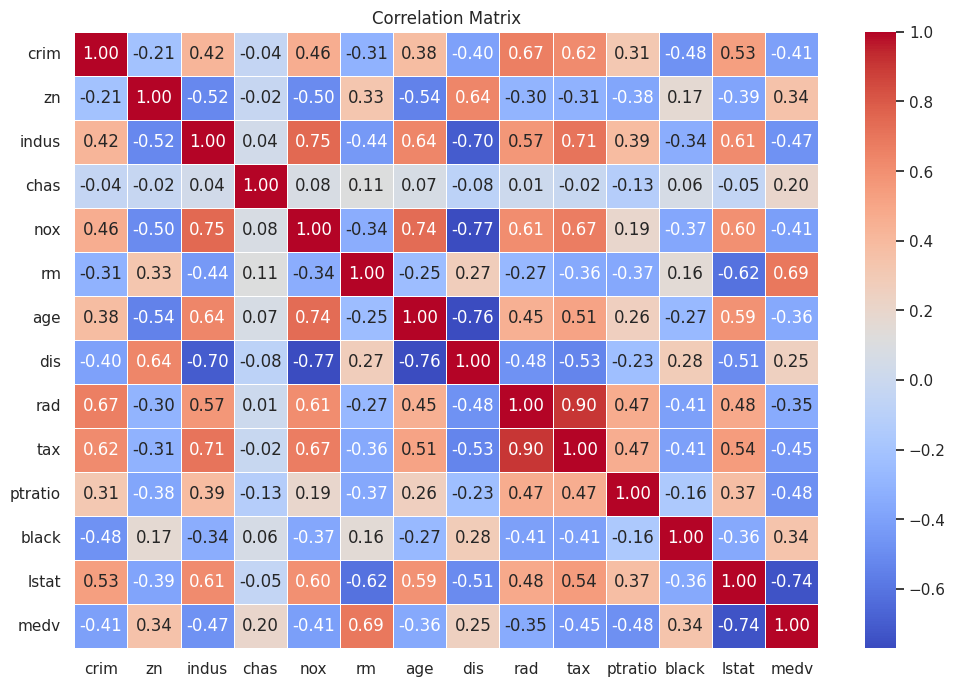

In [ ]:
# Correlation matrix
corr_matrix = train_df.corr()

# Visualizing the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

>Let’s split our data into a training set and a validation set. We will hold out 30% of the data for validation. We will use a random state to make our experiment reproducible.

In [ ]:
X = train_df.drop('medv', axis=1) ## The medv variable is the target variable, so we'll drop it from the features
y = train_df['medv']



X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

> Let’s establish a baseline by training a linear regression model.

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print('Training score: {}'.format(lr_model.score(X_train, y_train)))
print('Test score: {}'.format(lr_model.score(X_test, y_test)))

y_pred = lr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
# rmse = math.sqrt(mse)

print('MSE: {}'.format(mse))

Training score: 0.7268827869293253
Test score: 0.7254687959254529
MSE: 21.041489159411135


>The model above should give us a training accuracy and a test accuracy of about 72%. We should also get an MSE of about 21. The next models we train should outperform this model with higher accuracy scores and a lower MSE.

>We need to engineer new features. Specifically, we need to create polynomial features by taking our individual features and raising them to a chosen power. Thankfully, scikit-learn has an implementation for this and we don’t need to do it manually.

>Something else we would like to do is standardize our data. This scales our data down to a range between 0 and 1. This serves the purpose of letting us work with reasonable numbers when we raise to a power.

>Finally, because we need to carry out the same operations on our training, validation, and test sets, we will introduce a pipeline. This will let us pipe our process so the same steps get carried out repeatedly.

>To summarize, we will scale our data, then create polynomial features, and then train a linear regression model.

In [ ]:
steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())
]

pipeline = Pipeline(steps)

pipeline.fit(X_train, y_train)

print('Training score: {}'.format(pipeline.score(X_train, y_train)))
print('Test score: {}'.format(pipeline.score(X_test, y_test)))

Training score: 0.9475767600691033
Test score: 0.46762684971881674


>After running our code, we will get a training accuracy of about 94.75%, and a test accuracy of 46.76%. This is a sign of overfitting. It’s normally not a desirable feature, but that is exactly what we were hoping for.

>We will now apply regularization to our new data.

#L2 Regularization or Ridge Regression

>To understand Ridge Regression, we need to remind ourselves of what happens during gradient descent, when our model coefficients are trained. During training, our initial weights are updated according to a gradient update rule using a learning rate (which in class we've called alpha... but you'll see in a second that we won't call it alpha here) and a gradient (which is just the derivative of the cost function). Ridge regression adds a penalty to the update, and as a result shrinks the size of our weights. This is implemented in scikit-learn as a class called Ridge, docs found [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)..

>We will create a new pipeline, this time using Ridge. We will specify our regularization strength by passing in a parameter, alpha.  In class we called this parameter lambda, which is the convention for regularization ... so don't ask me why they use alpha here!  But like we discussed in class, when alpha = 0, the objective is equivalent to ordinary least squares regression.  But this value can be really small, like 0.1, or as large as you would want it to be. The larger the value of alpha, the less variance your model will exhibit.

> Try it out!  Test this with different values of alpha (or lambda like we called it in class).

In [ ]:
steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Ridge(alpha=10, fit_intercept=True))
]

ridge_pipe = Pipeline(steps)
ridge_pipe.fit(X_train, y_train)

print('Training Score: {}'.format(ridge_pipe.score(X_train, y_train)))
print('Test Score: {}'.format(ridge_pipe.score(X_test, y_test)))

Training Score: 0.9181086448043114
Test Score: 0.8287450913722826


>By executing the code, we should have a training accuracy of about 91.8%, and a test accuracy of about 82.87%. That is an improvement on our baseline linear regression model.

> But let’s try something else.

# L1 Regularization or Lasso Regression

>By creating a polynomial model, we created additional features. The question we need to ask ourselves is which of our features are relevant to our model, and which are not.

>L1 regularization tries to answer this question by driving the values of certain coefficients down to 0. This eliminates the least important features in our model. We will create a pipeline similar to the one above, but using Lasso. You can play around with the value of alpha, which can range from 0.1 to 1. Check out the Lasso docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).

In [ ]:
steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Lasso(alpha=0.3, fit_intercept=True))
]

lasso_pipe = Pipeline(steps)

lasso_pipe.fit(X_train, y_train)

print('Training score: {}'.format(lasso_pipe.score(X_train, y_train)))
print('Test score: {}'.format(lasso_pipe.score(X_test, y_test)))

Training score: 0.8483818643379695
Test score: 0.8307977758339726


>The code above should give us a training accuracy of 84.8%, and a test accuracy of 83%. This is an even better model than the one we trained earlier.

> Ok and now lets add some code so that we can compare these models. As we go forward in the class (when we discuss decision trees and SVMs etc) we can add to this.  But for now, this is how we'll compare these three models.



>At this point, you can evaluate your model by finding the MSE but we'll talk about other evalulation metrics going forward.  



In [ ]:
# Function to evaluate a model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Initialize the models
models = {
    "Linear Regression": pipeline,
    "Ridge Regression": ridge_pipe,
    "Lasso Regression": lasso_pipe,
}

# Evaluate each model
results = {}
for name, model in models.items():
    mse = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[name] = {"Mean Squared Error": mse}

# Display the results
for name, metrics in results.items():
    print(f"{name} - Mean Squared Error: {metrics['Mean Squared Error']:.4f}")

Linear Regression - Mean Squared Error: 40.8038
Ridge Regression - Mean Squared Error: 13.1259
Lasso Regression - Mean Squared Error: 12.9685


<ipython-input-23-d2db0dc11a2e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=mse_values, palette='viridis')


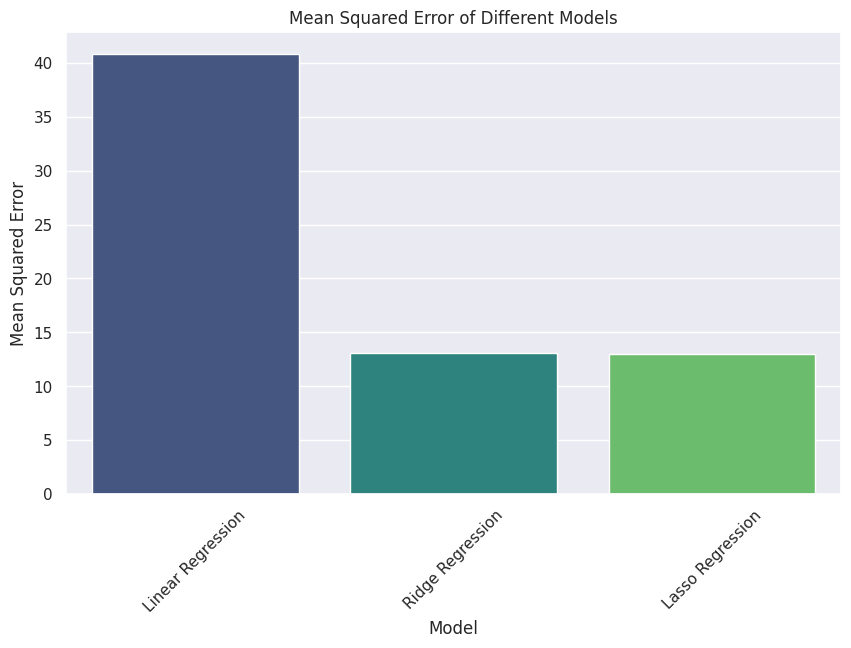

In [ ]:
# Data for plotting
models = list(results.keys())
mse_values = [results[model]["Mean Squared Error"] for model in models]

# Plot Mean Squared Error
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=mse_values, palette='viridis')
plt.title('Mean Squared Error of Different Models')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)
plt.show()